### TESLA Stock prediction

| 평가문항 | 상세기준 |
| -- | -- |
|1. 시계열의 안정성이 충분히 확인되었는가? | 플로팅과 adfuller 메소드 사용으로 시계열의 안정성이 (충분히) 확인되는 것을 시각화하였으며, 이에 대한 충분한 설명(해당 메소드에 대한 이해)이 서술되어있음|
|2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가? | p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨|
|3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?|3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨|

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

### 1. 애플 주식 데이터 분석

제 핸드폰은 아이폰입니다. 고로 애플 주식을 확인해보겠습니다.

### 1.1 데이터셋 로드 & 추세 확인

In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/'
df=pd.read_csv(dataset_filepath+"AAPL.csv", index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-04-03,41.910000,42.187500,41.220001,42.097500,40.132435,121112000
2018-04-04,41.220001,43.002499,41.192501,42.902500,40.899860,138422000
2018-04-05,43.145000,43.557499,43.020000,43.200001,41.183468,107732800
2018-04-06,42.742500,43.119999,42.049999,42.095001,40.130051,140021200
2018-04-09,42.470001,43.272499,42.462502,42.512501,40.528069,116070800


In [3]:
# 시계열 오름차순 정렬
df = df.sort_index(ascending=True, axis=0)
ts = df['Close']

In [4]:
ts.head()

Date
2018-04-03    42.097500
2018-04-04    42.902500
2018-04-05    43.200001
2018-04-06    42.095001
2018-04-09    42.512501
Name: Close, dtype: float64

종가 기준 애플 주식 데이터셋의 추세를 그래프로 확인해보겠습니다.

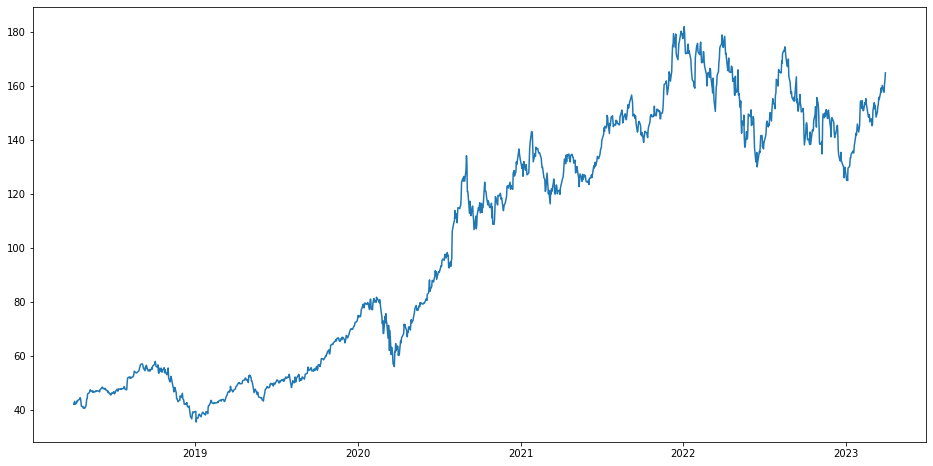

In [5]:
plt.figure(figsize=(16,8))
plt.plot(ts,label='Close Price history')

### 1.2 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [7]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

#### 1) 원본데이터 시계열 안정성 분석

a) 정성적 그래프 분석, 시계열 분해

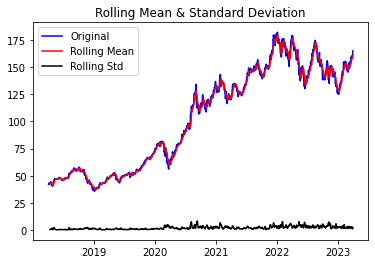

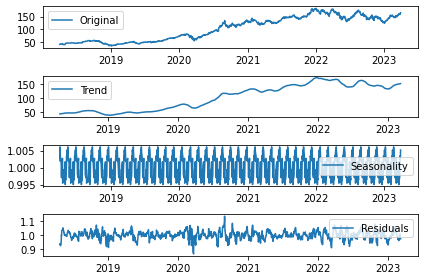

In [8]:
# 정성적 그래프 분석(window 7 - 일주일)
plot_rolling_statistics(ts, window=7)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [9]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.483948e+00
p-value                        3.806929e-16
#Lags Used                     2.100000e+01
Number of Observations Used    1.207000e+03
Critical Value (1%)           -3.435779e+00
Critical Value (5%)           -2.863938e+00
Critical Value (10%)          -2.568046e+00
dtype: float64


b) 원본데이터 정량적 시계열 정상성 확인

> __Augmented Dickey-Fuller Test__
>
> Augmented Dickey-Fuller Test(ADF Test)기반 시계열 데이터의 통계적 안정성(stationary) 테스트
>
> 1. 주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후,
> 2. 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에
> 3. 이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택한다

In [10]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                   -0.812559
p-value                           0.815405
#Lags Used                       11.000000
Number of Observations Used    1247.000000
Critical Value (1%)              -3.435605
Critical Value (5%)              -2.863861
Critical Value (10%)             -2.568005
dtype: float64


##### 해석: pvalue > 0.05 이므로 귀무가설을 기각할 수 없다... 따라서 원본 애플 주식 데이터는 비정상성 데이터로 판단된다.

</br>

### 1.3 비정상성(Non-stationary)의 정상성(Stationary) 변환

- 목적: 정상성 확보를 통해 안정성 향상에 따른 예측력 개선

- 장점: 절약성 원칙(Principle of Pasimony, 파라미터를 적게 써도 됨)에 따라 적은 모수만으로 모델링 가능하기에 과적합 확률이 낮아짐
> - 비정상성 데이터는 범위가 무제한에 해당하고, 정상성 데이터는 범위를 제한해주기 때문에 예측이 더 쉬워지지만 무조건 정상성 변환이 필요한 것은 아님
> - 정상성 변화을 할 경우 모델이 단조로워지기 때문에 과적합 확률이 낮아짐
- 방법: 제곱, 루트, 로그, 차분 등



#### 1) 로그 변환 후 ADF 테스트

- 시간흐름에 비례하여 값이 커지는 경우(분산 증가)
- 비정상 확률 과정으로 표준편차가 자료의 크기에 비례하여 증가하거나 지수함수적으로 증가하는 경우
- 로그 변환한 확률 과정의 분산은 일정하기에 추세 제거로 기댓값이 0이 되면 정상 과정으로 모형화 가능


In [11]:
# 로그 변환으로 정상성 확보 시도
ts_log = np.log(ts)

augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -1.012856
p-value                           0.748547
#Lags Used                        9.000000
Number of Observations Used    1249.000000
Critical Value (1%)              -3.435596
Critical Value (5%)              -2.863857
Critical Value (10%)             -2.568004
dtype: float64


##### 해석: 로그변환한 데이터 ADF 테스트 결과 pvalue > 0.05 이므로 아직 귀무가설을 기각할 수 없다...

#### 2) 로그변환 데이터 정성적 그래프 분석

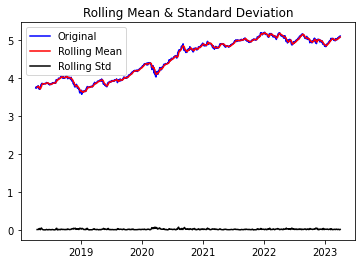

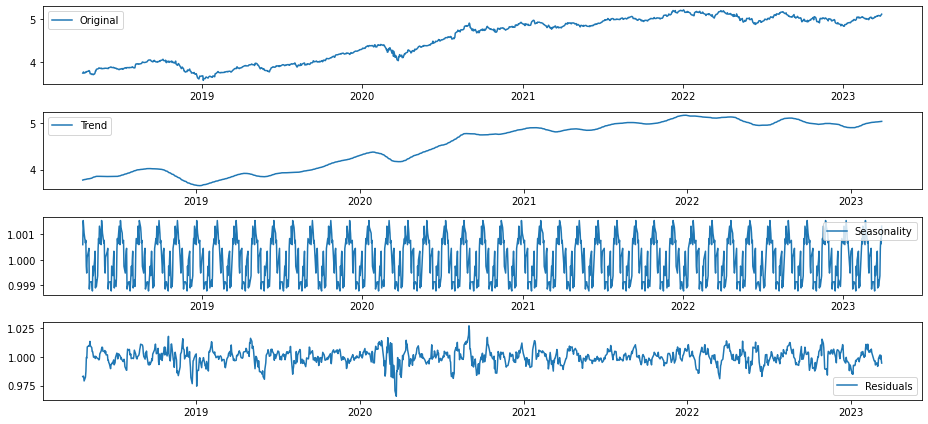

In [12]:
# 정성적 그래프 분석(window 7 - 일주일)
plot_rolling_statistics(ts_log, window=7)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (13,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [13]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.384606e+00
p-value                        6.812303e-16
#Lags Used                     1.900000e+01
Number of Observations Used    1.209000e+03
Critical Value (1%)           -3.435770e+00
Critical Value (5%)           -2.863934e+00
Critical Value (10%)          -2.568044e+00
dtype: float64


#### 3) 차분(Difference) 후 ADF 테스트

- 특정 시점 또는 시점들의 데이터가 발산할 경우, 시점간 차분(변화량)으로 정상성 변환 가능
- ARIMA 학습 전 시계열적으로 안정된 상태인지 확인

Results of Dickey-Fuller Test:
Test Statistic                -1.098558e+01
p-value                        7.273685e-20
#Lags Used                     8.000000e+00
Number of Observations Used    1.249000e+03
Critical Value (1%)           -3.435596e+00
Critical Value (5%)           -2.863857e+00
Critical Value (10%)          -2.568004e+00
dtype: float64


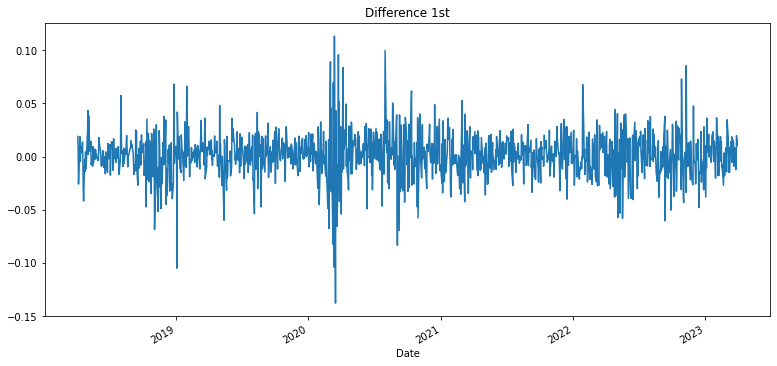

In [14]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

##### 해석> pvalue가 0.05미만이므로 가설 기각(채택), 1차 차분 처리한 데이터부터 정상성 데이터가 된 것을 확인할 수 있다.

=> 차분을 이용하여 안정적으로 만들어 분석할 수 있어 ARIMA를 사용하는 것이 좋다고 판단함

### 1.4 ARIMA 모수 추정
#### 1) ACF, PACF 그래프 사용

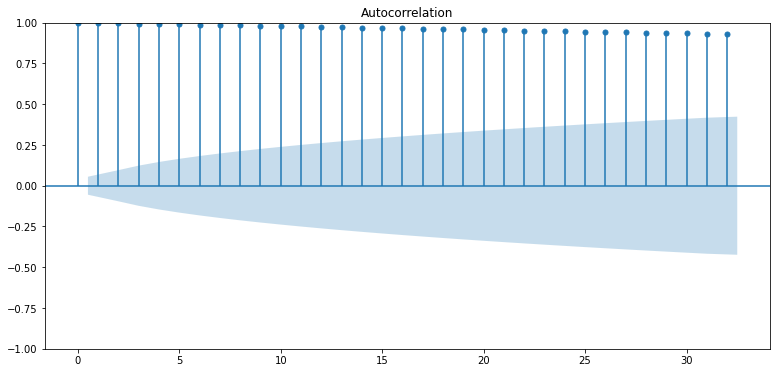

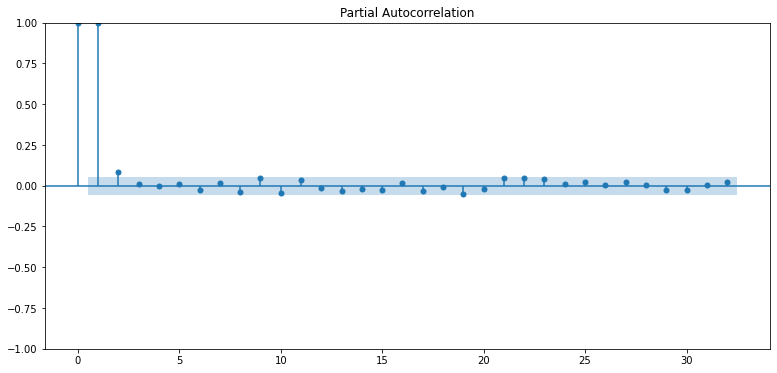

In [17]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


해석: ACF plot가 천천히 감소되는 것으로 보아 주식 데이터는 주기에 따라 일정하지 않은 비정상성 데이터이고,
PACF plot에서 첫값으로부터 2개 이후 파란 박스에 들어가면서 그래프가 끊긴다.

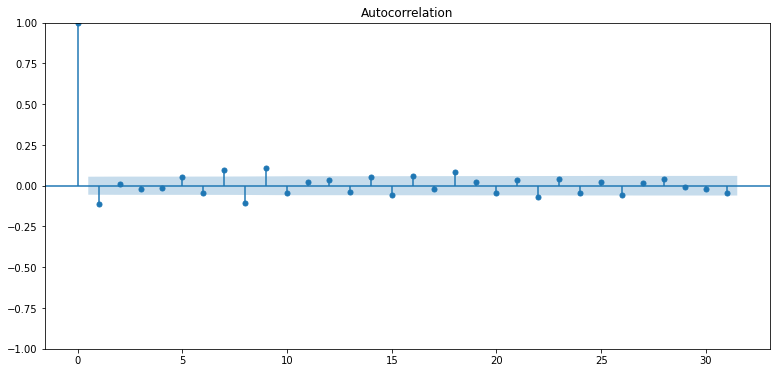

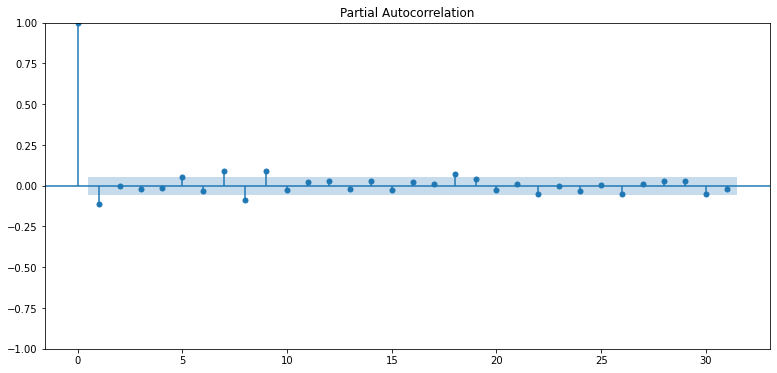

In [22]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

해석: ACF 그래프가 첫 값으로부터 1개 이후 파란 박스에 들어간다.

결론: ACF, PACF 그래프를 그려본 결과, AR(1), 차분 d(1), MA(0)이 적절해 보이지만... 확실하지 않아 보인다.

#### 2) ndiffs, Auto_arima 함수 사용

In [28]:
import pmdarima as pm
from pmdarima.arima import ndiffs

n_diffs = ndiffs(ts_log, alpha=0.05, test='adf', max_d=6)
print(f"추정된 차수 d = {n_diffs}") # 결과

추정된 차수 d = 1


In [29]:
model = pm.auto_arima(
            y=ts_log, 
            d=1, 
            start_p=0, max_p=3, 
            start_q=0, max_q=3, 
            m=1, seasonal=False, # 계절성이 없음!
            stepwise=True,
            trace=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6138.820, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6152.838, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6152.746, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6137.483, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6150.840, Time=1.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6150.838, Time=0.76 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6148.841, Time=1.45 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6150.688, Time=0.14 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 4.748 seconds


auto_arima기반 가장 좋은 모델은 (1,1,0)으로 결정되었다.

In [31]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1259
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3079.419
Date:                Mon, 03 Apr 2023   AIC                          -6152.838
Time:                        17:45:08   BIC                          -6137.426
Sample:                             0   HQIC                         -6147.046
                               - 1259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.001      2.013      0.044    3.18e-05       0.002
ar.L1         -0.1125      0.019     -6.074      0.000      -0.149      -0.076
sigma2         0.0004   1.06e-05     41.223      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               895.40
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.30
Prob(H) (two-sided):                  0.03   Kurtosis:                         7.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

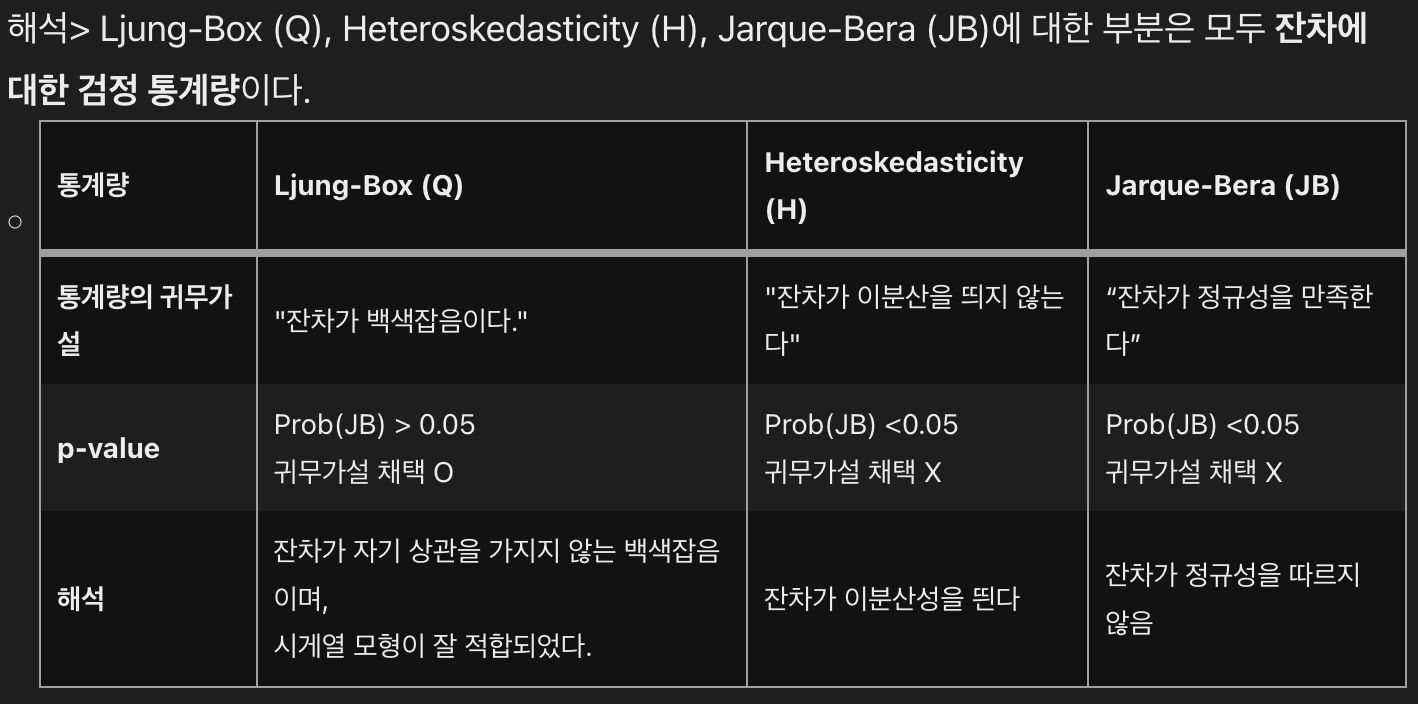

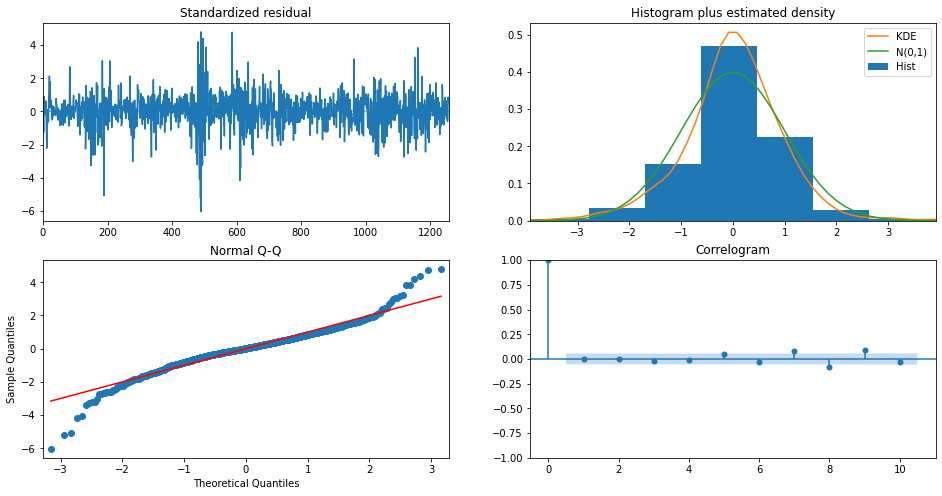

In [33]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

- 해석1. 잔차의 정상성
 - Standardized residual(좌상단) : 잔차의 시계열 데이터. 잔차의 시계열이 평균 0을 중심으로 변동하는 것으로 보임.
 - Correlogram (우하단) : 잔차에 대한 ACF 플롯. 어느정도 허용 범위(파란박스) 안에 위치하여 자기상관이 없음을 알 수 있음.


- 해석2. 잔차의 정규성
 - Histogram plus estimated density (우상단) : 잔차의 히스토그램을 그려 정규분포(N(0,1))와 밀도를 추정한 그래프.
 - Normal Q-Q (좌하단) : 양끝쪽 빨간 선을 벗어나는 구간이 존재한다. 정규성을 만족하려면 빨간 일직선 위에 점들이 분포해야 함.

#### 결론: 잔차는 백색잡음(정상성)이지만, 정규성은 따르지 않는다. 따라서 추후 모형 설정에서 여러 파라미터(모수)들을 변경하거나 데이터를 변환해가며 모형을 테스트해본다.



### 1.5 ARIMA 모델 학습

#### 1) train, test 데이터 분리

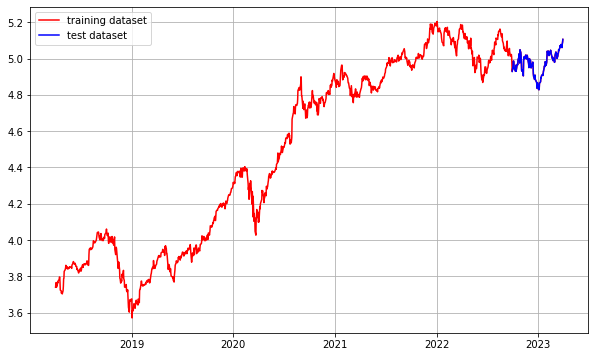

In [40]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### 2) train_data 모델 학습

In [41]:
# train_data 모델 학습
from statsmodels.tsa.arima_model import ARIMA

model_fit = pm.auto_arima(
            y=train_data, 
            d=n_diffs , 
            start_p=0, max_p=2, 
            start_q=0, max_q=2, 
            m=1, seasonal=False, # 계절성이 없음!
            stepwise=True,
            trace=True
)
print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5522.296, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5537.637, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5537.151, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5521.342, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5535.723, Time=1.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5535.751, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5533.705, Time=1.79 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5535.840, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 4.256 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1133
Model:               SARIMAX(1, 1, 0)   Log Likelihood                2771.819
Date:                Mon, 03 Apr 2023   AIC                          -5537.637
Time:                       

#### 3) 모델 예측

In [43]:
# forecast 함수
def forecast_n_step(model, n = 1):
    fc, conf_int = model.predict(n_periods=n, return_conf_int=True)
    # print("fc", fc,"conf_int", conf_int)
    return (
        fc.tolist()[0:n], np.asarray(conf_int).tolist()[0:n]
   )

def forecast(len, model, index, data=None):
    y_pred = []
    pred_upper = []
    pred_lower = []

    if data is not None:
        for new_ob in data:
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(new_ob)
    else:
        for i in range(len):
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(fc[0])
    return pd.Series(y_pred, index=index), pred_upper, pred_lower

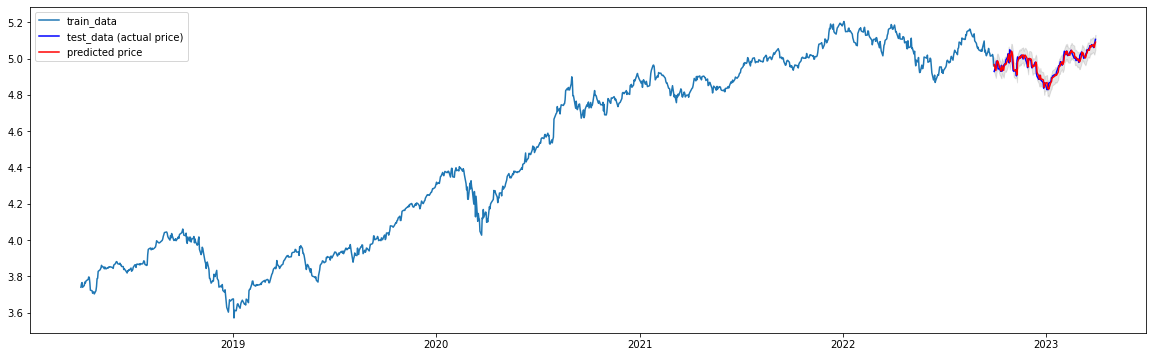

In [44]:
# Forecast 
fc, upper, lower = forecast(len(test_data), model_fit, test_data.index, data = test_data)

# pandas series 생성
# fc # 예측결과
lower_series = pd.Series(lower, index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(upper, index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(20,6))
plt.plot(train_data, label='train_data')
plt.plot(test_data, c='b', label='test_data (actual price)')
plt.plot(fc, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend(loc='upper left')
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: ' ,'{:.2f}%'.format(mape*100))

MSE:  9.18438231791323
MAE:  2.3537050794943184
RMSE:  3.0305745854397363
MAPE:  1.63%


최종적으로 에측 모델의 메트릭으로 활용하기에 적당한 MAPE 기준으로 1.63%의 오차율을 보임

### 2. 테슬라 주식 데이터 분석

어머니께서 최근에 테슬라 주식을 구매하셔서 동향을 예측해볼 예정입니다.

예제에 맞춰 종가를 기준으로 예측해보겠습니다.

In [46]:
df2 = pd.read_csv(dataset_filepath+'TSLA.csv', index_col='Date', parse_dates=True)

# 시계열 오름차순 정렬
df2 = df2.sort_values('Date', ascending=True)
ts2 = df2['Close']

ts2.head()

Date
2018-04-03    17.835333
2018-04-04    19.129333
2018-04-05    20.381332
2018-04-06    19.953333
2018-04-09    19.310667
Name: Close, dtype: float64

Series([], Name: Close, dtype: float64)


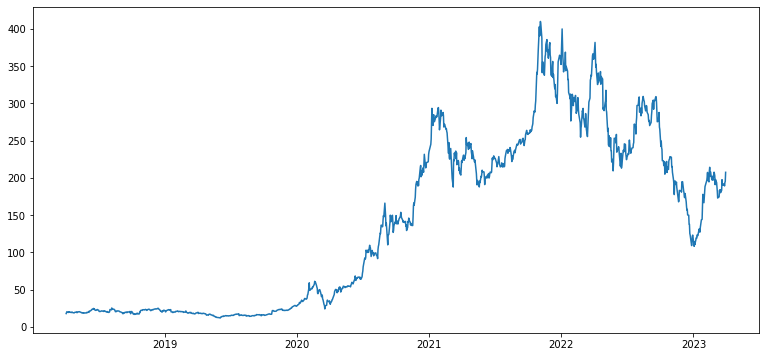

In [47]:
# 결측치가 있다면 이를 보간합니다. (보간 기준: time)
ts2=ts2.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무 확인
print(ts2[ts2.isna()])

plt.plot(ts2)

- 해당 기간 내 Tesla 데이터의 결측치는 없는 것으로 확인되었습니다.

- 그래프로 확인해본 데이터의 추세는 낮아지고 있으며 시간이 지남에 따라 변동성이 커지는 비정상성 데이터에 해당됩니다.

In [49]:
# 로그 변환으로 정상성 확보 시도
ts_log2 = np.log(ts2)

augmented_dickey_fuller_test(ts_log2)

Results of Dickey-Fuller Test:
Test Statistic                   -1.015319
p-value                           0.747636
#Lags Used                        0.000000
Number of Observations Used    1258.000000
Critical Value (1%)              -3.435559
Critical Value (5%)              -2.863840
Critical Value (10%)             -2.567995
dtype: float64


#### 정성적, 정량적 분석

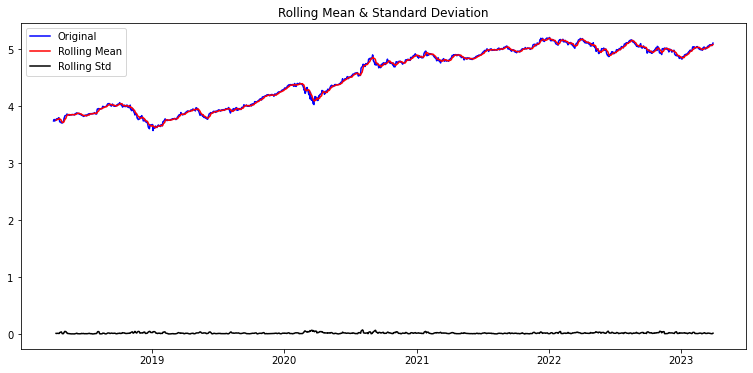

Results of Dickey-Fuller Test:
Test Statistic                   -1.012856
p-value                           0.748547
#Lags Used                        9.000000
Number of Observations Used    1249.000000
Critical Value (1%)              -3.435596
Critical Value (5%)              -2.863857
Critical Value (10%)             -2.568004
dtype: float64


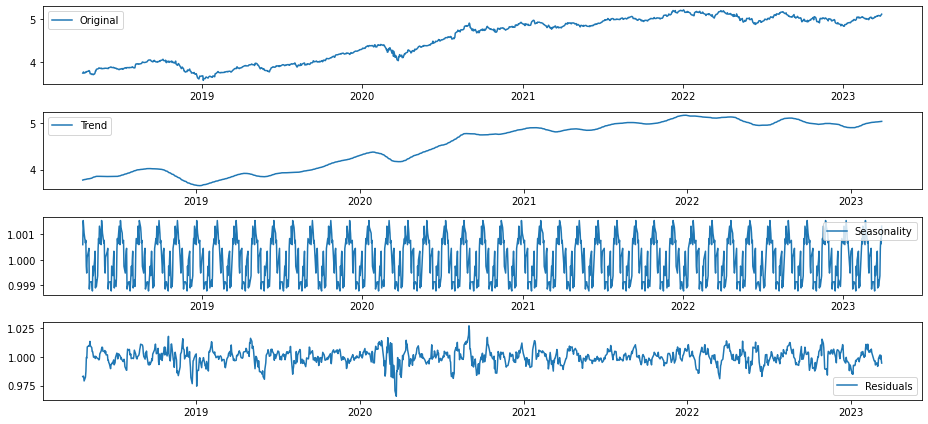

In [48]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=6)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [103]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.391409
p-value                          0.000307
#Lags Used                       9.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


### 학습, 테스트 데이터셋 생성

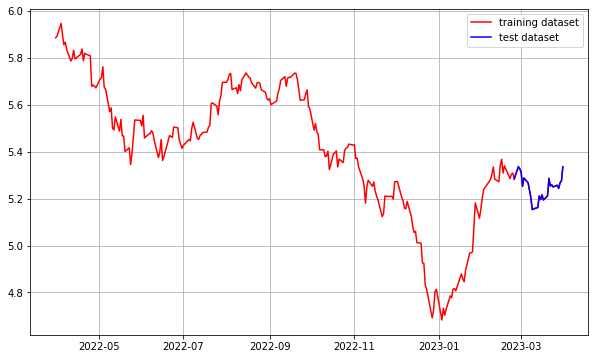

In [105]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 적정 ARIMA 모수 찾기

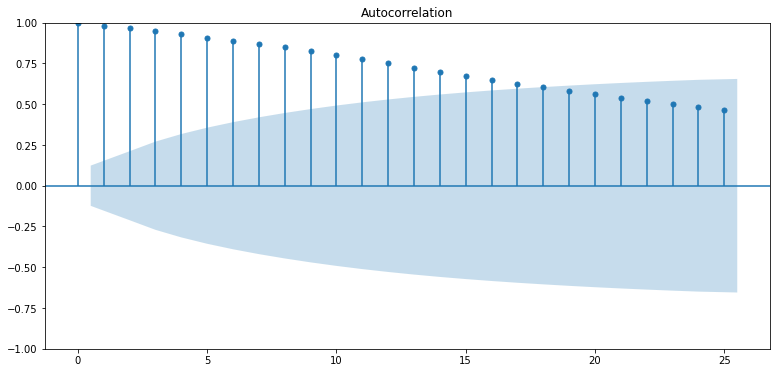

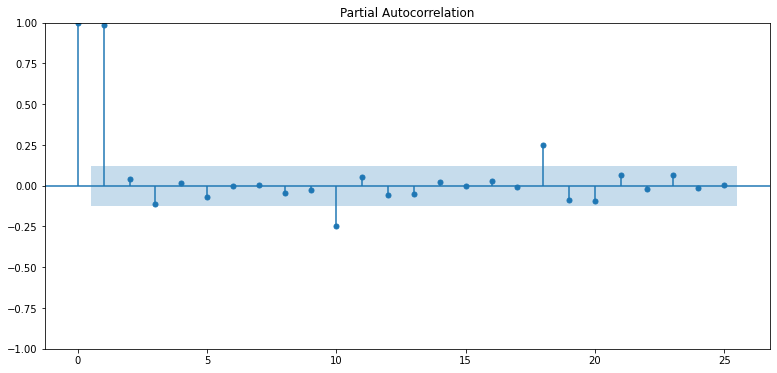

In [106]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### ARIMA 모델 훈련과 테스트

In [109]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 389.188
Date:                Mon, 03 Apr 2023   AIC                           -768.376
Time:                        13:25:22   BIC                           -751.273
Sample:                             0   HQIC                          -761.474
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5041      0.191     28.811      0.000       5.130       5.879
ar.L1          0.2897      0.336      0.862      0.388      -0.369       0.948
ar.L2          0.6943      0.328      2.115      0.0

ARIMA 모델 훈련결과 확인

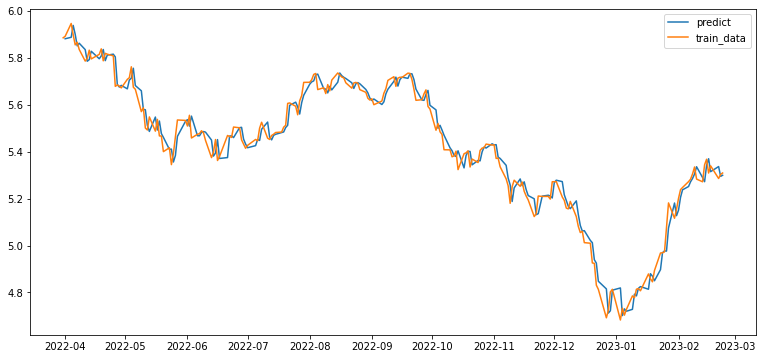

In [119]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

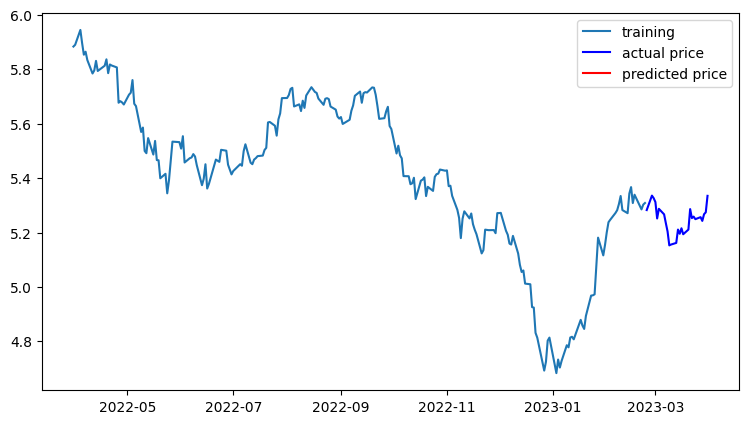

In [120]:
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

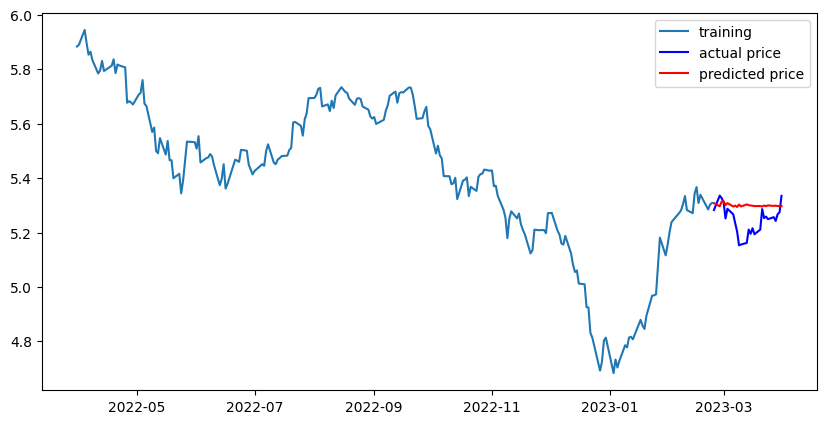

In [121]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

### MSE, MAE, RMSE, MAPE 값 확인

In [111]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  391.889929264488
MAE:  17.425551982644155
RMSE:  19.796209972226702
MAPE: 9.43%


#### 시계열 데이터의 통계적 특성 확인하기 

일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해보는 함수

현재 타임 스텝 부터 window에 주어진 타임 스텝 이전 사이

- 구간의 평균(rolling mean, 이동평균)과
- 구간의 표준편차(rolling std, 이동표준편차)

를 원본 시계열과 함께 시각화해 보면 좀 더 뚜렷한 경향성을 확인할 수 있을 것입니다.



> 아래 코드에서 window는 다음 정의에서 특정 개수(d)에 해당합니다.
> - 이동평균(Moving Average. 혹은 Rolling Mean)
>
> 이동평균이란 시계열 데이터에서 특정 개수(d)의 데이터를 시점(t)을 이동하며 계산하는 평균입니다.
>
>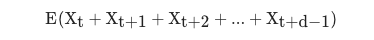
> - 이동표준편차(Rolling std)
> 
> 이동표준편차란 시계열 데이터에서 특정 개수(d)의 데이터를 시점(t)을 이동하며 계산하는 표준편차입니다. (표준편차는 분산에 제곱근을 씌운 값입니다.
>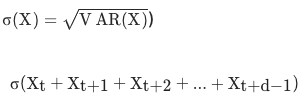

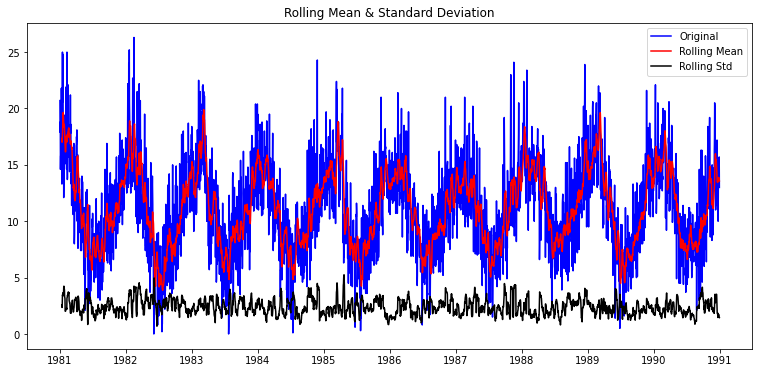

In [10]:
plot_rolling_statistics(ts1, window=12)

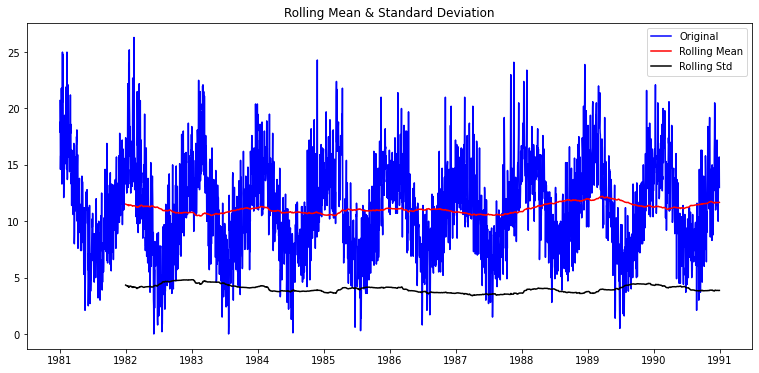

In [11]:
plot_rolling_statistics(ts1, window=365)

In [16]:
augmented_dickey_fuller_test(ts1)

Results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


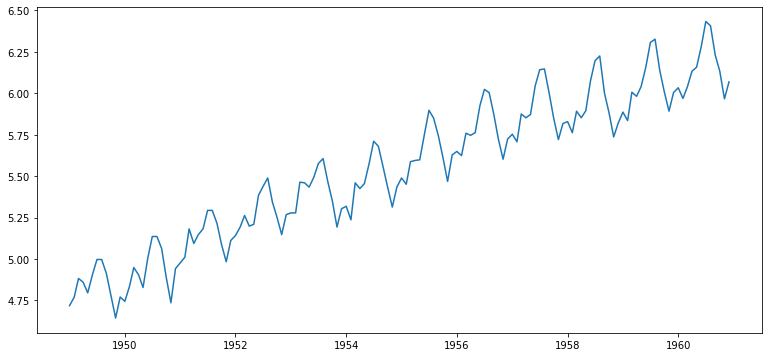

In [17]:
ts_log = np.log(ts2)
plt.plot(ts_log)

In [18]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


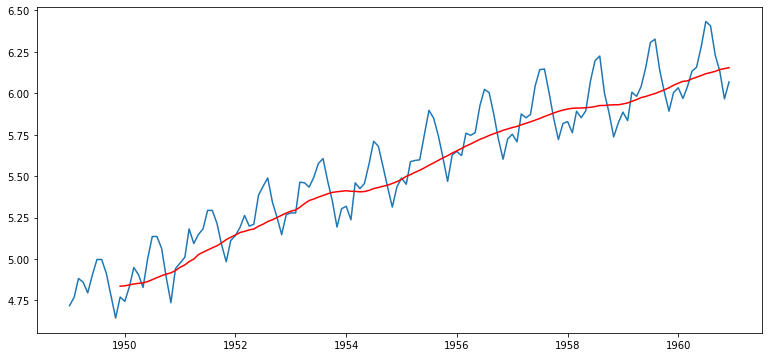

In [19]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [20]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: Passengers, dtype: float64

In [21]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
Name: Passengers, dtype: float64

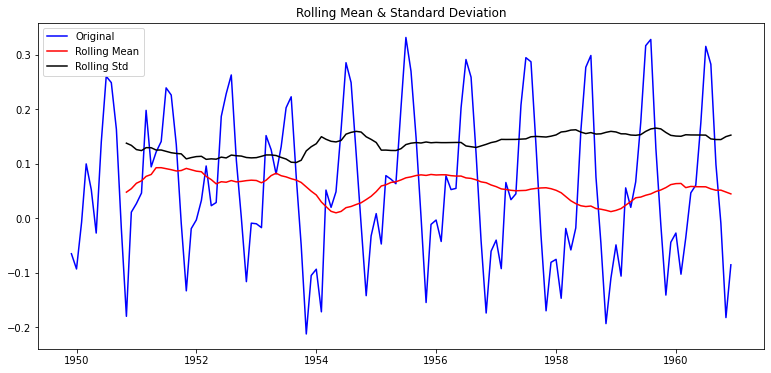

In [22]:
plot_rolling_statistics(ts_log_moving_avg)

In [23]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


드디어 p-value가 0.02 수준이 되었습니다. 95% 이상의 confidence로 이 time series는 stationary하다고 할 수 있겠습니다.

만약 위 코드에서 window=6을 적용하면 어떤 결과가 나올까요?

In [122]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

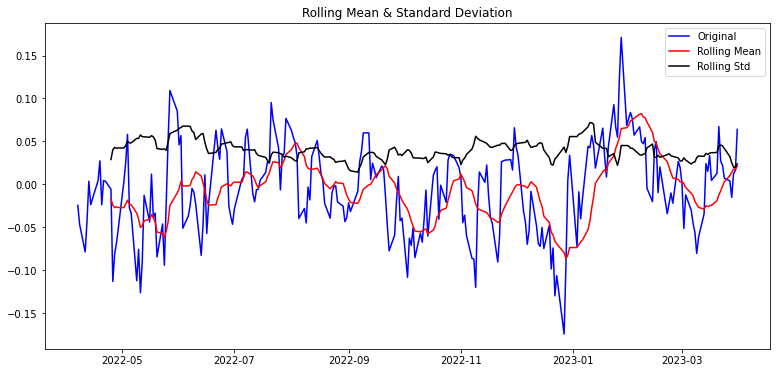

In [123]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [26]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                  -2.273822
p-value                          0.180550
#Lags Used                      14.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


## 1-3. 차분(Differencing) - 계절성(Seasonality) 상쇄하기


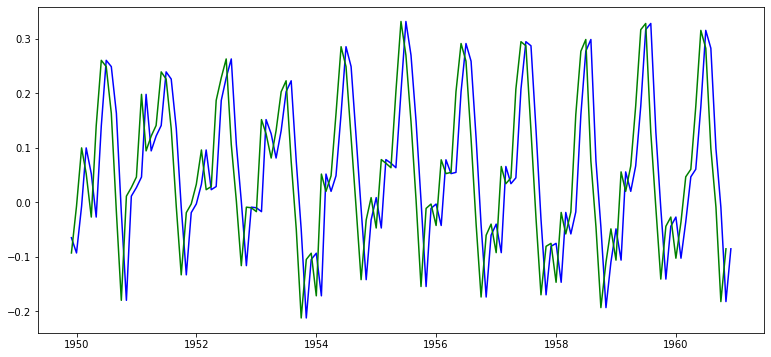

In [27]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

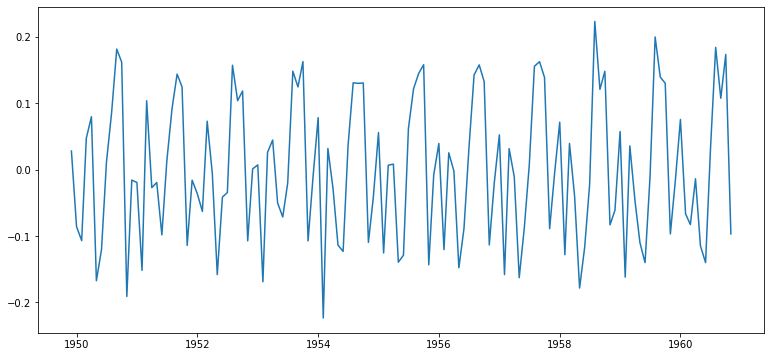

In [28]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

## 2. 시계열 분해(Time series decomposition)

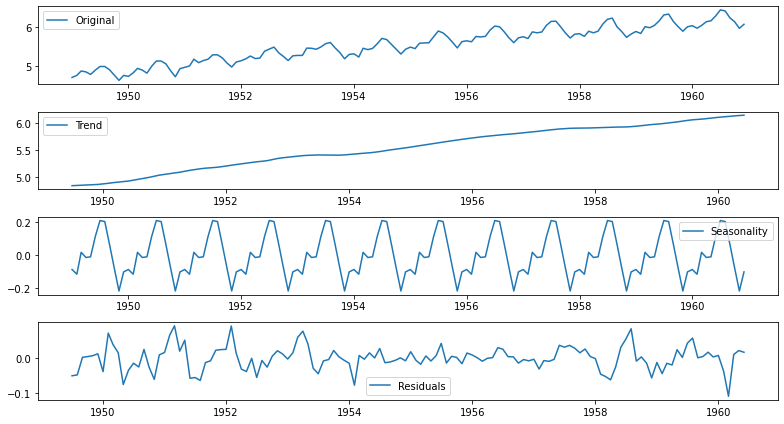

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

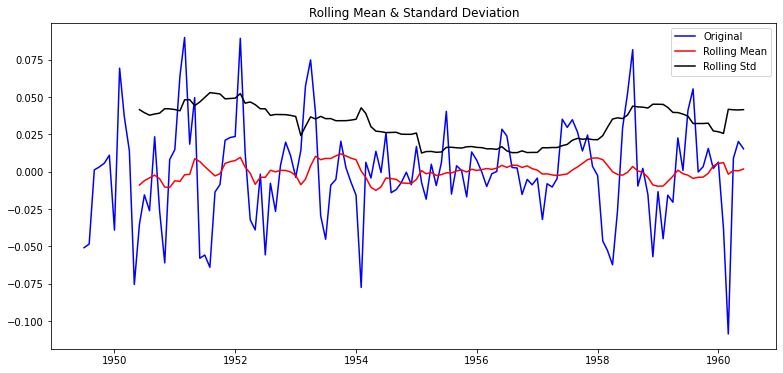

In [30]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [31]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


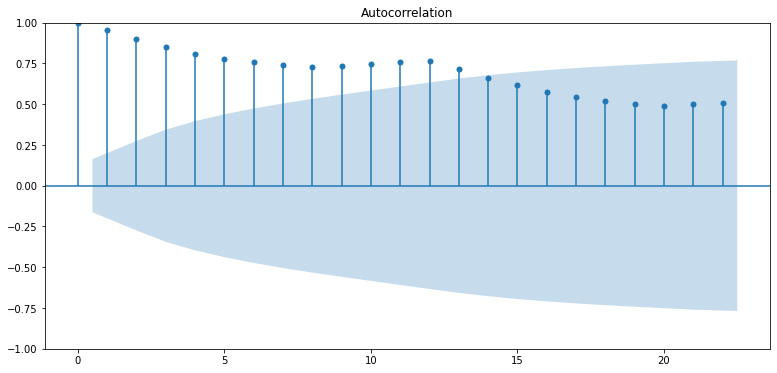

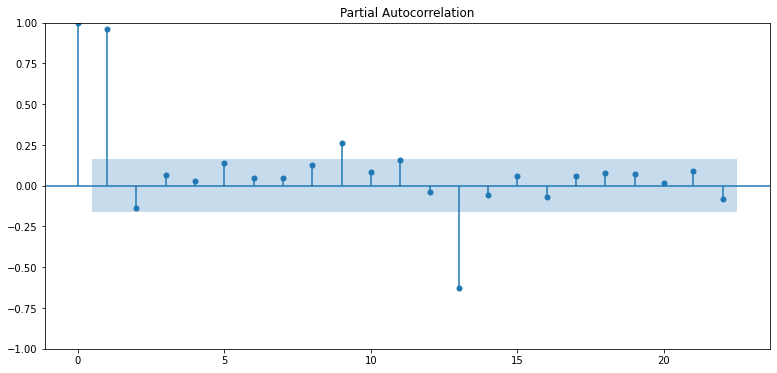

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


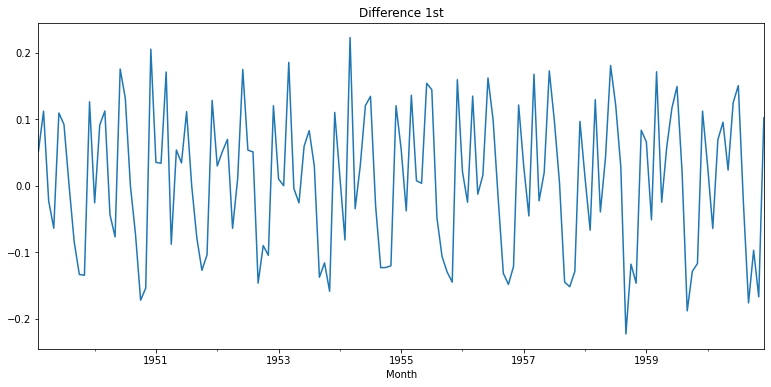

In [33]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


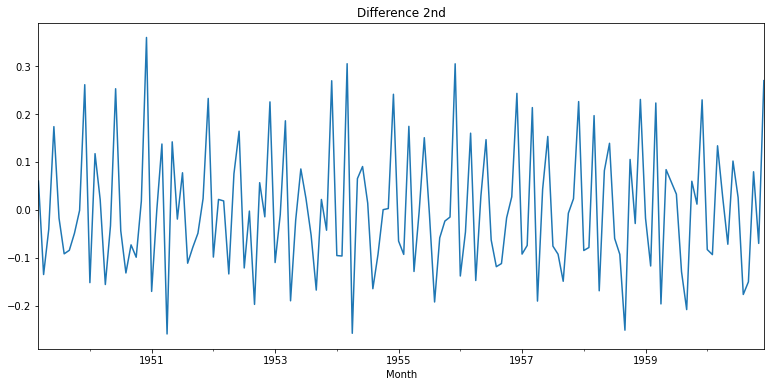

In [34]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## 3. 학습 데이터 분리


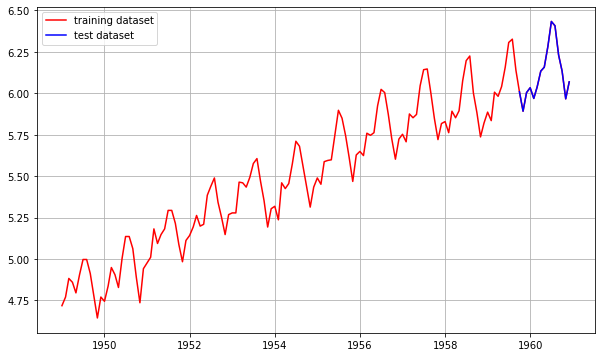

In [35]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [36]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: Passengers, dtype: float64
(129,)
(15,)


## 4-8. ARIMA 모델 훈련과 추론

ARIMA 모델을 훈련하는 것은 아래와 같이 간단합니다.

In [37]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(14, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  129
Model:                ARIMA(14, 1, 0)   Log Likelihood                 219.942
Date:                Mon, 03 Apr 2023   AIC                           -409.883
Time:                        10:59:43   BIC                           -367.103
Sample:                    01-01-1949   HQIC                          -392.502
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2651      0.081     -3.277      0.001      -0.424      -0.107
ar.L2         -0.0044      0.108     -0.040      0.968      -0.216       0.208
ar.L3          0.0021      0.046      0.046      0.9

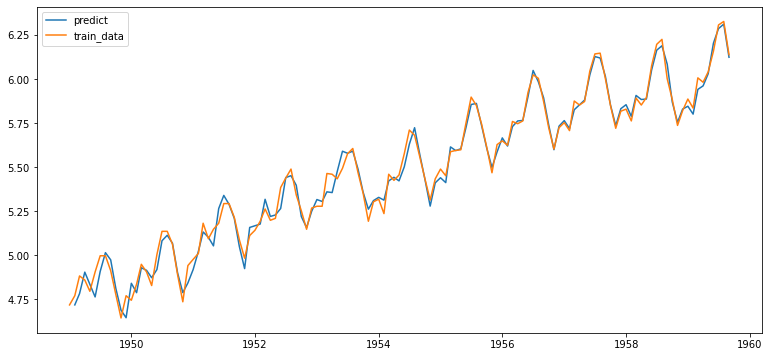

In [38]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

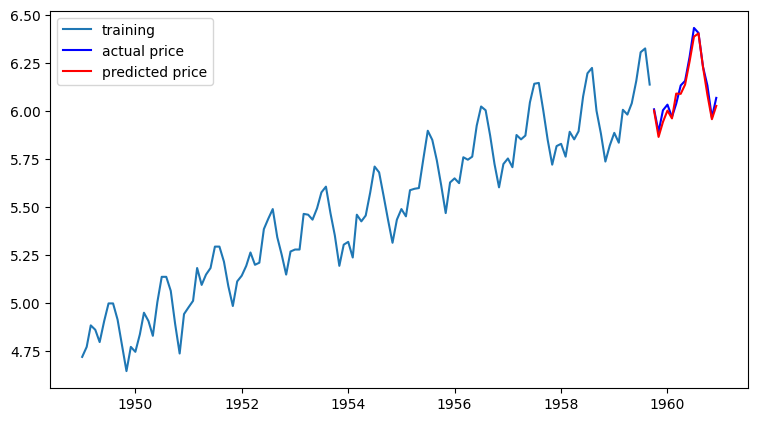

In [39]:
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  236.27939252509398
MAE:  12.55810531713422
RMSE:  15.371382258115045
MAPE: 2.76%


## 4-9. 프로젝트 : 주식 예측에 도전해 보자

In [41]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


STEP 1 : 시계열 데이터 준비

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [56]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284
...,...,...,...,...,...,...
2021-05-12,80800.0,81200.0,79800.0,80000.0,80000.000000,35812268
2021-05-13,78900.0,79600.0,78400.0,78500.0,78500.000000,31490096
2021-05-14,79000.0,80300.0,78900.0,80100.0,80100.000000,16450920


STEP 2 : 각종 전처리 수행

In [46]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [47]:
# 로그 변환 시도 
ts_log = np.log(ts)

STEP 3 : 시계열 안정성 분석
> - 정성적 그래프 분석
> - 정량적 Augmented Dicky-Fuller Test
> - 시계열 분해(Time Series Decomposition)
> - Residual 안정성 확인

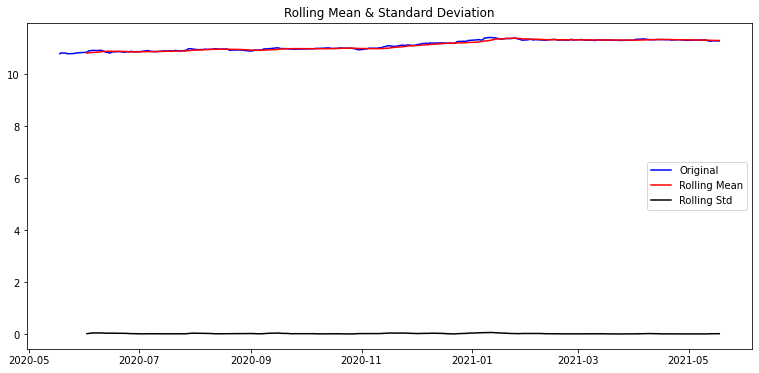

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


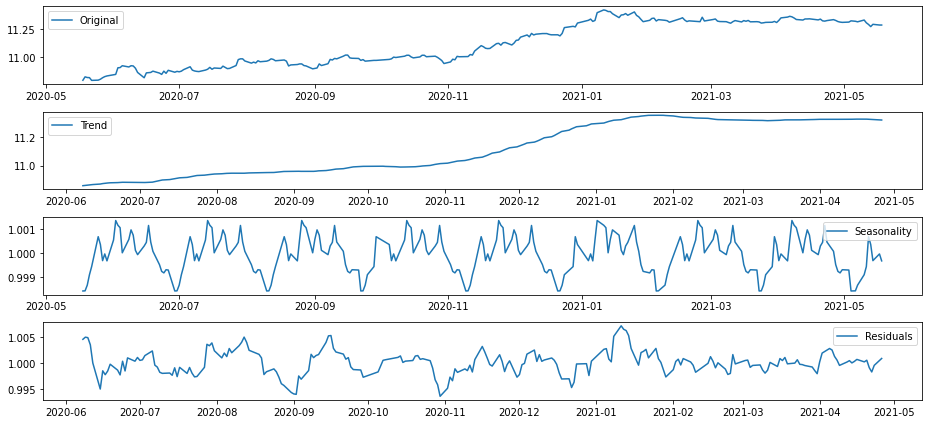

In [48]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [49]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


STEP 4 : 학습, 테스트 데이터셋 생성

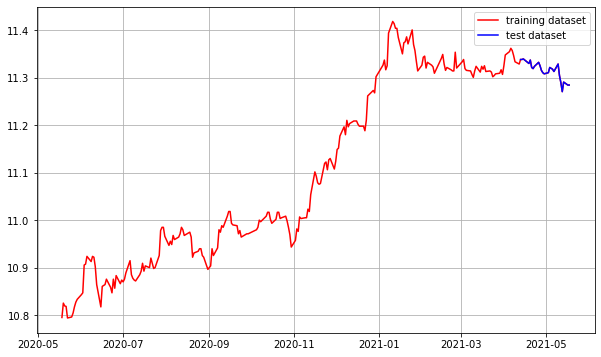

In [50]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

STEP 5 : 적정 ARIMA 모수 찾기

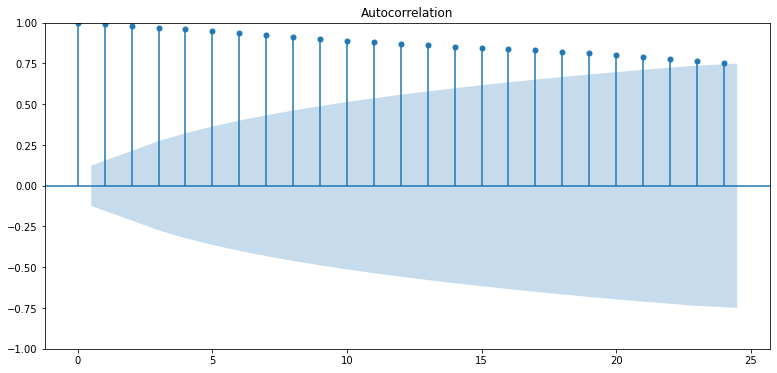

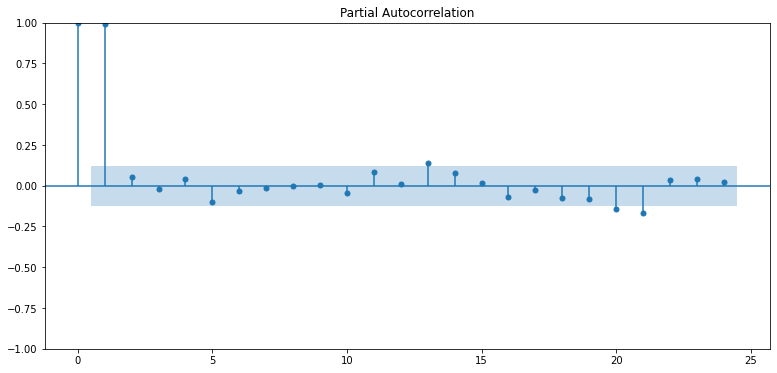

In [51]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


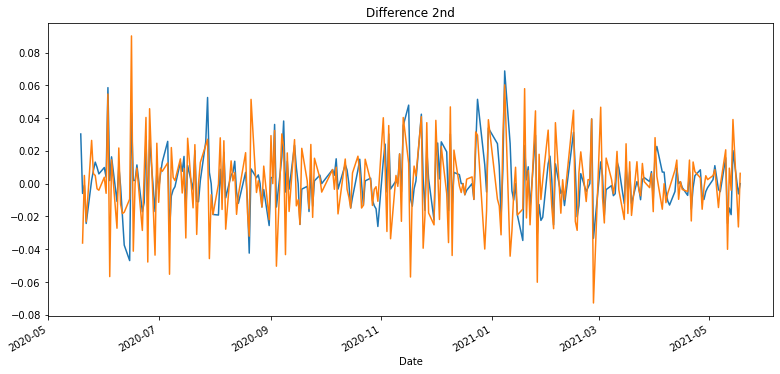

In [52]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

STEP 6 : ARIMA 모델 훈련과 테스트

In [53]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Mon, 03 Apr 2023   AIC                          -1156.722
Time:                        11:05:34   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

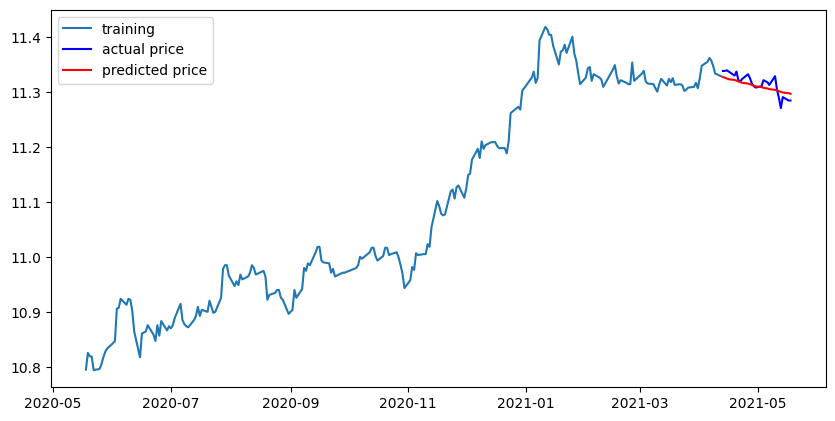

In [54]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


STEP 7 : 다른 주식 종목 예측해 보기


최종적으로 에측 모델의 메트릭으로 활용하기에 적당한 MAPE 기준으로 9.43%의 오차율을 보임